<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_sprint9_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Prepare Dataset

In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [ ]:
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

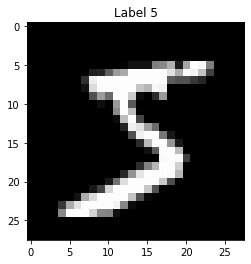

In [ ]:
index = 0
image = X_train[index].reshape(28, 28)
plt.imshow(image, 'gray', vmin=0, vmax=255)
plt.title(f"Label {y_train[index]}")
plt.show()

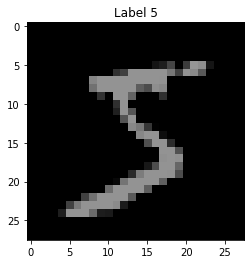

In [ ]:
index = 0
image = X_train[index].reshape(28,28).astype(np.float)
image -= 105.35
plt.imshow(image, 'gray', vmin=0, vmax=255)
plt.title(f"Label {y_train[index]}")
plt.show()

In [ ]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.min(), X_train.max())

0.0 1.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 784), (12000, 784), (48000,), (12000,))

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = enc.transform(y_val.reshape(-1, 1))

y_train.shape, y_train_one_hot.shape, y_val.shape, y_val_one_hot.shape

((48000,), (48000, 10), (12000,), (12000, 10))

## Mini Batch Processing

In [ ]:
class GetMiniBatch():
    """
    Iterator to get a mini-batch
    @Parameters
        X : The following forms of ndarray, shape (n_samples, n_features)
            Training data
        y : The following form of ndarray, shape (n_samples, 1)
            Correct answer value
        batch_size : int
            Batch size
        seed : int
            NumPy random number seed
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# [Problem 1] Creating a code to determine the initial weight value

In [ ]:
def init_weight(l0_dim=1, l1_dim=1, sigma=0.01, bias=True, seed=0):
    """
    @Parameters:
        l0_dim: number of nodes in current layer
        l1_dim: number of nodes in the next layer
        sigma: Standard deviation of Gaussian distribution
    @Return:
        Matrix of initial weight value following Gaussian distribution
    """
    np.random.seed(seed)
    s = 1 if bias else 0
    return sigma * np.random.randn(l0_dim + s, l1_dim)

In [ ]:
print("[Layer 1] Input dimension:", X_train.shape)
w = init_weight(X_train.shape[1], 400, bias=False)
print("Init weight dimension:", w.shape)
input_next_layer = X_train @ w
print("[Layer 2] dimension:", input_next_layer.shape)

[Layer 1] Input dimension: (48000, 784)
Init weight dimension: (784, 400)
[Layer 2] dimension: (48000, 400)


# [Problem 2] Implementation of forward propagation

In [ ]:
def sigmoid(X):
    return 1 / (1 + np.exp(X))
def tanh(X):
    return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
def softmax(X):
    return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)

In [ ]:
a = np.arange(15).reshape(5, 3)
a, sigmoid(a), tanh(a), softmax(a)

(array([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]]),
 array([[5.00000000e-01, 2.68941421e-01, 1.19202922e-01],
        [4.74258732e-02, 1.79862100e-02, 6.69285092e-03],
        [2.47262316e-03, 9.11051194e-04, 3.35350130e-04],
        [1.23394576e-04, 4.53978687e-05, 1.67014218e-05],
        [6.14417460e-06, 2.26032430e-06, 8.31528028e-07]]),
 array([[0.        , 0.76159416, 0.96402758],
        [0.99505475, 0.9993293 , 0.9999092 ],
        [0.99998771, 0.99999834, 0.99999977],
        [0.99999997, 1.        , 1.        ],
        [1.        , 1.        , 1.        ]]),
 array([[0.09003057, 0.24472847, 0.66524096],
        [0.09003057, 0.24472847, 0.66524096],
        [0.09003057, 0.24472847, 0.66524096],
        [0.09003057, 0.24472847, 0.66524096],
        [0.09003057, 0.24472847, 0.66524096]]))

In [ ]:
def feed_forward(X, W, activation=sigmoid, bias=True):
    if bias: X = np.c_[np.ones(X.shape[0]), X]
    A = X @ W
    return A, activation(A)

In [ ]:
batch_size = 20
n_features = 784    # Number of input features
n_nodes1 = 400      # Number of first layer nodes
n_nodes2 = 200      # Number of second layer nodes
n_output = 10       # Number of output classes (third layer)
mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size)

# Layer 1
A0 = mini_batch[0][0]
w1 = init_weight(n_features, n_nodes1, bias=False)
w1_bias = init_weight(n_features, n_nodes1, bias=True)

A1, Z1 = feed_forward(A0, w1, bias=False, activation=tanh)
A1_bias, Z1_bias = feed_forward(A0, w1_bias, bias=True, activation=tanh)

print("Input shape:", A0.shape)
print("Init weight shape:", w1.shape)
print("Init weight with bias shape:", w1_bias.shape)
print("Output shape:", A1.shape)
print("Output with bias shape:", A1_bias.shape)

Input shape: (20, 784)
Init weight shape: (784, 400)
Init weight with bias shape: (785, 400)
Output shape: (20, 400)
Output with bias shape: (20, 400)


In [ ]:
# Layer 2
w2 = init_weight(n_nodes1, n_nodes2, bias=False)
w2_bias = init_weight(n_nodes1, n_nodes2, bias=True)

A2, Z2 = feed_forward(Z1, w2, bias=False, activation=tanh)
A2_bias, Z2_bias = feed_forward(Z1_bias, w2_bias, bias=True, activation=tanh)

print("Input shape:", Z1.shape)
print("Input with bias shape:", Z1_bias.shape)
print("Init weight shape:", w2.shape)
print("Init weight with bias shape:", w2_bias.shape)
print("Output shape:", A2.shape)
print("Output with bias shape:", A2_bias.shape)

Input shape: (20, 400)
Input with bias shape: (20, 400)
Init weight shape: (400, 200)
Init weight with bias shape: (401, 200)
Output shape: (20, 200)
Output with bias shape: (20, 200)


In [ ]:
# Layer 3 (Output using Softmax)
w3 = init_weight(n_nodes2, n_output, bias=False)
w3_bias = init_weight(n_nodes2, n_output, bias=True)

A3, Z3 = feed_forward(Z2, w3, bias=False, activation=softmax)
A3_bias, Z3_bias = feed_forward(Z2_bias, w3_bias, bias=True, activation=softmax)

print("Input shape:", Z2.shape)
print("Input with bias shape:", Z2_bias.shape)
print("Init weight shape:", w3.shape)
print("Init weight with bias shape:", w3_bias.shape)
print("Output shape:", A3.shape)
print("Output with bias shape:", A3_bias.shape)

Input shape: (20, 200)
Input with bias shape: (20, 200)
Init weight shape: (200, 10)
Init weight with bias shape: (201, 10)
Output shape: (20, 10)
Output with bias shape: (20, 10)


# [Problem 3] Implementation of cross entropy error

In [ ]:
def cross_entropy_loss(y_true, y_proba, tol=1e-7):
    """
    @Params:
        y_true: correct labels
        y_proba: probabilities of class label
    @Return:
        Cross entropy error
    """
    error_per_sample = np.sum(y_true * np.log(y_proba + tol), axis=1)
    L = -np.mean(error_per_sample)
    return L

In [ ]:
print("L:", cross_entropy_loss(mini_batch[0][1], Z3))
print("L with bias:", cross_entropy_loss(mini_batch[0][1], Z3_bias))

L: 2.3031138319596907
L with bias: 2.3032139701582013


# [Problem 4] Implementation of backpropagation

In [ ]:
def backpropagation(W, Z, L_A, bias=True):
    """
    @Params:
        W: weights on links between previous and current layers
        Z: output of previous layer (after activation)
        L_A: loss over output of current layer (before activation)
    @Return:
        grad: gradient descent amount
        L_Z: loss over output of previous layer
    """
    if bias: Z = np.c_[np.ones(Z.shape[0]), Z]
    grad = Z.T @ L_A
    L_Z = L_A @ W.T
    if bias: L_Z = L_Z[:, 1:]
    return grad, L_Z

In [ ]:
# Layer 3
alpha = 0.01
L_A3 = (Z3 - mini_batch[0][1]) / batch_size
L_A3_bias = (Z3_bias - mini_batch[0][1]) / batch_size
grad_w3, L_Z2 = backpropagation(w3, Z2, L_A3, bias=False)
grad_w3_bias, L_Z2_bias = backpropagation(w3_bias, Z2_bias, L_A3_bias, bias=True)
w3 -= alpha * grad_w3
w3_bias -= alpha * grad_w3_bias
print(L_Z2.shape, L_Z2_bias.shape)

(20, 200) (20, 200)


In [ ]:
# Layer 2
L_A2 = L_Z2 * (1 - tanh(A2)**2)
L_A2_bias = L_Z2_bias * (1 - tanh(A2_bias)**2)
grad_w2, L_Z1 = backpropagation(w2, Z1, L_A2, bias=False)
grad_w2_bias, L_Z1_bias = backpropagation(w2_bias, Z1_bias, L_A2_bias, bias=True)
w2 -= alpha * grad_w2
w2_bias -= alpha * grad_w2_bias
print(L_Z1.shape, L_Z1_bias.shape)

(20, 400) (20, 400)


In [ ]:
# Layer 1
L_A1 = L_Z1 * (1 - tanh(A1)**2)
L_A1_bias = L_Z1_bias * (1 - tanh(A1_bias)**2)
grad_w1, _ = backpropagation(w1, A0, L_A1, bias=False)
grad_w1_bias, _ = backpropagation(w1_bias, A0, L_A1_bias, bias=True)
w1 -= alpha * grad_w1
w1_bias -= alpha * grad_w1_bias

# [Problem 5] Estimation

In [ ]:
A1, Z1 = feed_forward(A0, w1, bias=False, activation=tanh)
A1_bias, Z1_bias = feed_forward(A0, w1_bias, bias=True, activation=tanh)
A2, Z2 = feed_forward(Z1, w2, bias=False, activation=tanh)
A2_bias, Z2_bias = feed_forward(Z1_bias, w2_bias, bias=True, activation=tanh)
A3, Z3 = feed_forward(Z2, w3, bias=False, activation=softmax)
A3_bias, Z3_bias = feed_forward(Z2_bias, w3_bias, bias=True, activation=softmax)

In [ ]:
print("L:", cross_entropy_loss(mini_batch[0][1], Z3))
print("L with bias:", cross_entropy_loss(mini_batch[0][1], Z3_bias))

L: 2.3029831976198345
L with bias: 2.302402596673057


In [ ]:
np.argmax(Z3, axis=1), np.argmax(Z3_bias, axis=1), np.argmax(mini_batch[0][1], axis=1)

(array([0, 0, 3, 3, 1, 3, 3, 3, 7, 3, 3, 3, 0, 1, 0, 5, 3, 3, 0, 3]),
 array([3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4]),
 array([5, 0, 9, 6, 8, 2, 2, 8, 0, 2, 5, 1, 2, 2, 5, 3, 2, 4, 4, 8]))

## Implementation of Scratch Neural Network Classifier

In [ ]:
def tanh_grad(X):
    return 1 - tanh(X) ** 2
def sigmoid_grad(X):
    return sigmoid(X) * (1 - sigmoid(X))
def non_activate(X):
    return X

class Layer():
    """
    A layer of a fully connected Neural Network
    """
    activation_func = {
        "tanh": {
            "feed": tanh,
            "back": tanh_grad
        },
        "sigmoid": {
            "feed": sigmoid,
            "back": sigmoid_grad
        },
        "softmax": {
            "feed": softmax,
        },
        "non_activate": {
            "feed": non_activate,
            "back": non_activate
        }
    }
    def __init__(self, n_nodes, activation="non_activate",
                 bias=True, name="hidden"):
        self.n_nodes = n_nodes
        self.activation = activation if activation in self.activation_func else "non_activate"
        self.name = name
        self.bias = bias

    def feed(self, X):
        """
        @Params:
            input: (n_samples, self.n_nodes)
        """
        self.input = X
        self.output = self.activation_func[self.activation]["feed"](self.input)
        if self.bias: self.output = np.c_[np.ones(self.output.shape[0]), self.output]
        return self.output
    
    def back(self, X):
        return self.activation_func[self.activation]["back"](X)

In [ ]:
class ScratchSimpleNeuralNetworkClassifier():
    """
    Simple three-layer neural network classifier
    """
    def __init__(self, batch_size=1, epochs=10, layers=[],
                 sigma=0.02, lr=0.01, random_state=0, verbose=True):
        self.batch_size = batch_size
        self.epochs = epochs
        self.sigma = sigma
        self.lr = lr
        self.layers = layers
        self.verbose = verbose
        self.random_state = random_state
        np.random.seed(random_state)
    
    def add(self, layer):
        """
        @Params:
            layer: object of class Layer
        """
        self.layers.append(layer)
        return self
    
    def _init_weights(self):
        self.weights = []
        for i in range(len(self.layers) - 1):
            s = 1 if self.layers[i].bias else 0
            w = self.sigma * np.random.randn(self.layers[i].n_nodes + s,
                                             self.layers[i+1].n_nodes)
            self.weights.append(w)
    
    def _feedforward(self, X):
        Z = X.copy()
        for layer, weight in zip(self.layers[:-1], self.weights):
            A = layer.feed(Z)   # Activate input and add bias if needed
            Z = A @ weight
        output = self.layers[-1].feed(Z)
        return output
    
    def _backpropagation(self, y):
        grads = [0 for _ in range(len(self.weights))]
        D = self.layers[-1].output - y

        for i in range(len(self.weights) - 1, -1, -1):
            grads[i] = self.layers[i].output.T @ D
            if i == 0: break
            d = D @ self.weights[i].T
            if self.layers[i].bias: d = d[:, 1:]
            D = d * self.layers[i].back(self.layers[i].input)

        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * grads[i]

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.
        @Parameters
            X : The following forms of ndarray, shape (n_samples, n_features)
                Features of training data
            y : The following form of ndarray, shape (n_samples,)
                Correct answer value of training data
            X_val : The following forms of ndarray, shape (n_samples, n_features)
                Features of verification data
            y_val : The following form of ndarray, shape (n_samples,)
                Correct value of verification data
        """
        self._init_weights()
        self.train_loss = []
        self.val_loss = []
        for i in range(self.epochs):
            mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=self.random_state)
            for mini_X, mini_y in mini_batch:
                self._feedforward(mini_X)
                self._backpropagation(mini_y)

            self.train_loss.append(cross_entropy_loss(y, self.predict_proba(X)))
            if X_val is not None and y_val is not None:
                self.val_loss.append(cross_entropy_loss(y_val, self.predict_proba(X_val)))

            if self.verbose:
                print("Epoch", i, "Loss:", self.train_loss[-1])

        return self
    
    def predict_proba(self, X):
        return self._feedforward(X)

    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples,)
            Estimated result
        """
        y_proba = self._feedforward(X)
        return np.argmax(y_proba, axis=1)

# [Problem 6] Learning and estimation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

def evaluate(X, y, y_one_hot, model):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    print("ROC AUC:", roc_auc_score(y_one_hot, y_proba))
    print(classification_report(y, y_pred))
    sns.heatmap(confusion_matrix(y, y_pred), cmap=plt.cm.Blues, annot=True)
    plt.show()

In [ ]:
model = ScratchSimpleNeuralNetworkClassifier(batch_size=20, random_state=0)
model.add(Layer(n_nodes=784, bias=False, name="input"))
model.add(Layer(n_nodes=400, activation="tanh", bias=True, name="hidden_1"))
model.add(Layer(n_nodes=200, activation="tanh", bias=True, name="hidden_2"))
model.add(Layer(n_nodes=10, activation="softmax", bias=False, name="output"))

In [ ]:
model.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

Epoch 0 Loss: 0.19082541307140263
Epoch 1 Loss: 0.10636097089530866
Epoch 2 Loss: 0.07520065026738947
Epoch 3 Loss: 0.05785699018413772
Epoch 4 Loss: 0.04289198487235822
Epoch 5 Loss: 0.030398866207322177
Epoch 6 Loss: 0.02070236467705187
Epoch 7 Loss: 0.014908259189198405
Epoch 8 Loss: 0.010427765249832651
Epoch 9 Loss: 0.006166024439797372


ROC AUC: 0.9996319314124069
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1205
           1       0.99      0.99      0.99      1379
           2       0.98      0.98      0.98      1166
           3       0.98      0.97      0.97      1208
           4       0.98      0.97      0.98      1153
           5       0.97      0.97      0.97      1075
           6       0.98      0.98      0.98      1190
           7       0.98      0.99      0.98      1228
           8       0.97      0.98      0.97      1191
           9       0.97      0.97      0.97      1205

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



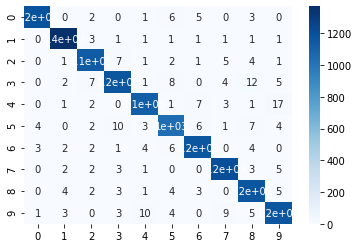

In [ ]:
evaluate(X_val, y_val, y_val_one_hot, model)

# [Problem 7] Learning curve plot

In [ ]:
def plot_learning_curve(train_loss, val_loss=None):
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train_loss", linewidth=5)
    if val_loss is not None:
        plt.plot(val_loss, label="val_loss", linewidth=5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

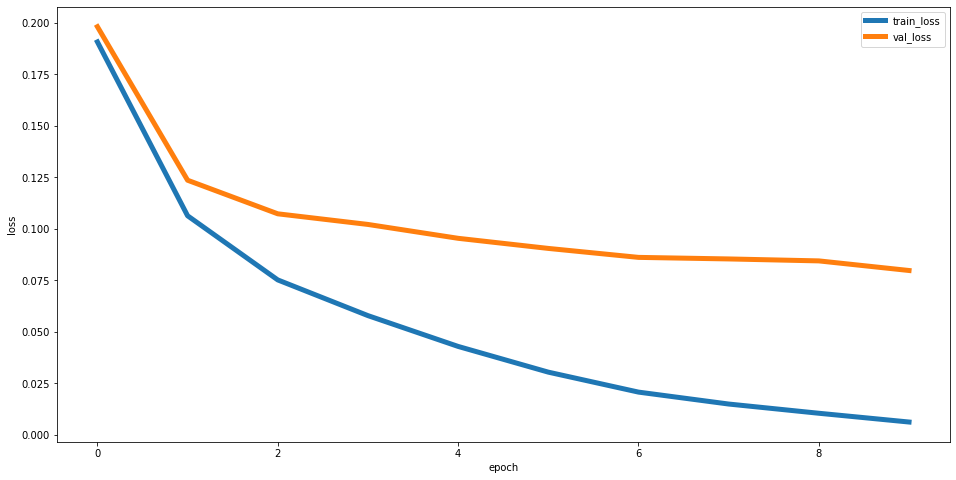

In [ ]:
plot_learning_curve(model.train_loss, model.val_loss)

It's looked somehow underfitting but the loss deviation (between train and validate set) is pretty small so it's fairly acceptable.

# [Problem 8] (Advance assignment) Confirmation of misclassification

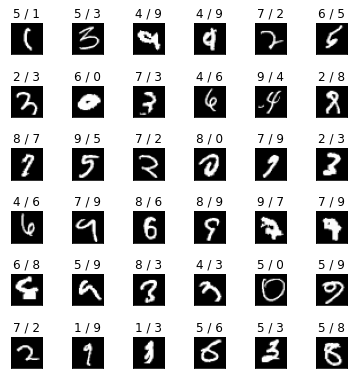

In [ ]:
"""
Display word classification results side by side. The display above the image is "estimated result / correct answer".
Parameters:
----------
y_pred : Estimated ndarray (n_samples,)
y_val : Correct label of verification data (n_samples,)
X_val : Verification data features (n_samples, n_features)
"""
num = 36 # How many to display

true_false = y_pred == y_val
false_list = np.where(true_false == False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]], y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')